# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [323]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os

In [324]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

(150, 150, 3)
(192, 192, 3)
(150, 150, 3)
(184, 184, 3)
(195, 200, 3)
(106, 108, 3)


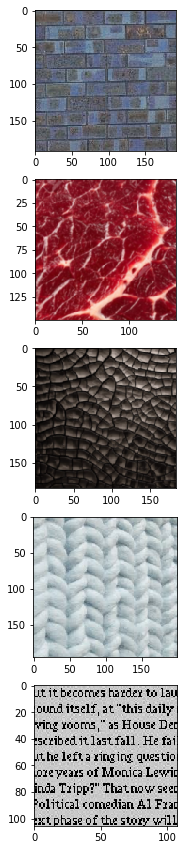

In [23]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
#     plt.imshow(sample_img)
meat = cv2.imread("samples/meat.jpg")
meat = cv2.pyrDown(cv2.pyrDown(meat))[25:175, 100:250, :]
print(meat.shape)
meat = cv2.cvtColor(meat, cv2.COLOR_BGR2RGB)
drought = cv2.imread("samples/drought.jpg")[:,:733,:]
drought = cv2.pyrDown(cv2.pyrDown(drought))

cotton = cv2.imread("samples/texture.png")
text = cv2.imread("samples/text_small.jpg")
fig, ax = plt.subplots(5,1,figsize=(15,15))
ax[0].imshow(sample_img)
print(sample_img.shape)
ax[1].imshow(meat)
print(meat.shape)
ax[2].imshow(drought)
print(drought.shape)
ax[3].imshow(cotton)
print(cotton.shape)
ax[4].imshow(text)
print(text.shape)

In [24]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    
    # Todo 
    output = np.zeros([out_size, out_size, 3])
    for i in range(0, out_size, patch_size):
        if out_size - i < patch_size:
            break
        for j in range(0, out_size, patch_size):
            if out_size - i < patch_size or out_size - j < patch_size:
                continue
            rand_x = np.random.randint(0, sample.shape[0] - patch_size)
            rand_y = np.random.randint(0, sample.shape[0] - patch_size)
            patch = sample[rand_x:rand_x + patch_size, rand_y : rand_y + patch_size, :]
            output[i:i + patch_size, j : j + patch_size,:] = patch
    return output

<IPython.core.display.Javascript object>


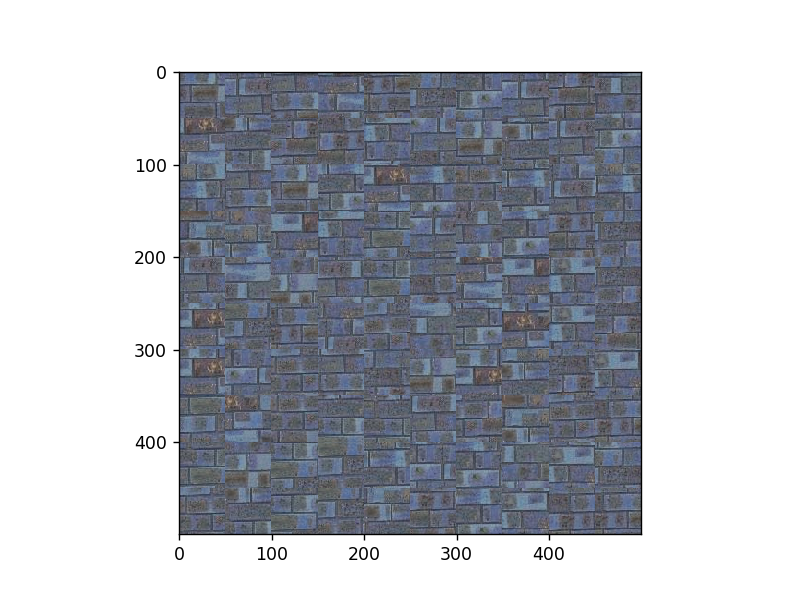

In [374]:
out_size = 500 # feel free to change to debug
patch_size = 50 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
res = res.astype("int64")

plt.imshow(res)

<IPython.core.display.Javascript object>


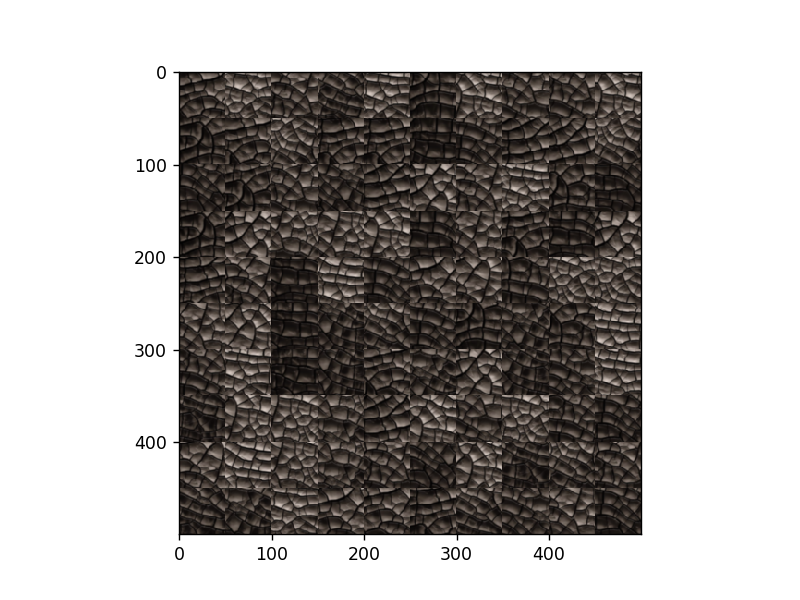

In [376]:
drought_1 = quilt_random(drought, 500, 50)
plt.imshow(drought_1.astype(int))

### Part II: Overlapping Patches (30 pts)

In [176]:
# def ssd_patch(M, T, I):
#     ## ssd 
#     ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
#     return ssd
    
# def choose_sample(sample, patch_size, M, T, true_sample, tol):
#     cost_image = np.zeros([sample.shape[0] - patch_size, sample.shape[0]- patch_size])
#     for i in range(sample.shape[0] - patch_size):
#         for j in range(sample.shape[0] - patch_size):
#             cost_image[i,j] = np.sum(ssd_patch(M, T, sample[i:i+patch_size, j : j + patch_size]))
# #     tenth_largest = np.sort(cost_image.ravel())[-10]
# #     x,y = np.where(cost_image >= tenth_largest)
# #     rand = np.random.randint(0,10)
# #     x,y = (x[rand], y[rand])
#     min_value = np.min(cost_image)
#     row, col = np.where(cost_image <= min_value *(1+tol))
#     index = np.random.randint(0, len(row))
#     x,y = row[index], row[index]
#     return sample[x : x + patch_size, y : y + patch_size], true_sample[x : x + patch_size, y : y + patch_size, :]

In [339]:
def get_all_patches(sample, patch_size):
    all_patches = {}
    count = -1
    for i in range(sample.shape[0]):
        if sample.shape[0] - i < patch_size:
            break
        for j in range(sample.shape[1]):
            if sample.shape[1] - j < patch_size:
                continue
            count += 1
            all_patches[count] = sample[i : i + patch_size, j : j + patch_size, :]
    return all_patches
            
        
def ssd_cost(M, T, I):
    useful_I = np.zeros(I.shape)
    useful_I[:,:,0], useful_I[:,:,1], useful_I[:,:,2] = M * I[:,:,0], M * I[:,:,1], M * I[:,:,2]
    return np.sum((T - useful_I) ** 2)

    
def choose_sample(sample, patch_size, M, T, tol, all_patches):
#     cost_image = np.zeros([sample.shape[0] - patch_size, sample.shape[0]- patch_size])
    proportion = 0.1
    cost_image = {}
    n = len(all_patches)
    index = np.random.choice(n, int(proportion * n))

    for i in index:
        cost_image[i] = ssd_cost(M, T, all_patches[i])
    
    min_value = min(cost_image.values())
    choices = []
    for key in cost_image.keys():
        if cost_image[key] <= min_value * (1 + tol):
            choices.append(all_patches[key])
    
    return choices[np.random.choice(len(choices))]

In [340]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    assert overlap < patch_size
    # Todo 
    
    sample = sample.copy() / 255.0
    patches = get_all_patches(sample, patch_size)
    step = patch_size - overlap
    output = np.zeros([out_size, out_size, 3])
    
    print(len(patches))
    for i in range(0, out_size + 1, step):
        if out_size - i < patch_size:
            break
        for j in range(0, out_size + 1, step):
            if out_size - j < patch_size:
                continue     
            print(i, j)
            
            if i == 0 and j == 0:
                index = np.random.choice(len(patches))
                q = index
                put_new_sample(i, j, overlap, patch_size, patches[index], output)
            
            M = (output[i : i + patch_size, j : j + patch_size, 0] != 0).astype(int)
            T = (output[i : i + patch_size, j : j + patch_size])
            
            new_sample = choose_sample(sample, patch_size, M, T, tol, patches)
#             put_grey_sample(i, j, overlap, patch_size, grey_sample, grey_output)
            put_new_sample(i, j, overlap, patch_size, new_sample, output)
    return output
            

12769
0 0
0 70
0 140
0 210
0 280
0 350
0 420
70 0
70 70
70 140
70 210
70 280
70 350
70 420
140 0
140 70
140 140
140 210
140 280
140 350
140 420
210 0
210 70
210 140
210 210
210 280
210 350
210 420
280 0
280 70
280 140
280 210
280 280
280 350
280 420
350 0
350 70
350 140
350 210
350 280
350 350
350 420
420 0
420 70
420 140
420 210
420 280
420 350
420 420


<IPython.core.display.Javascript object>


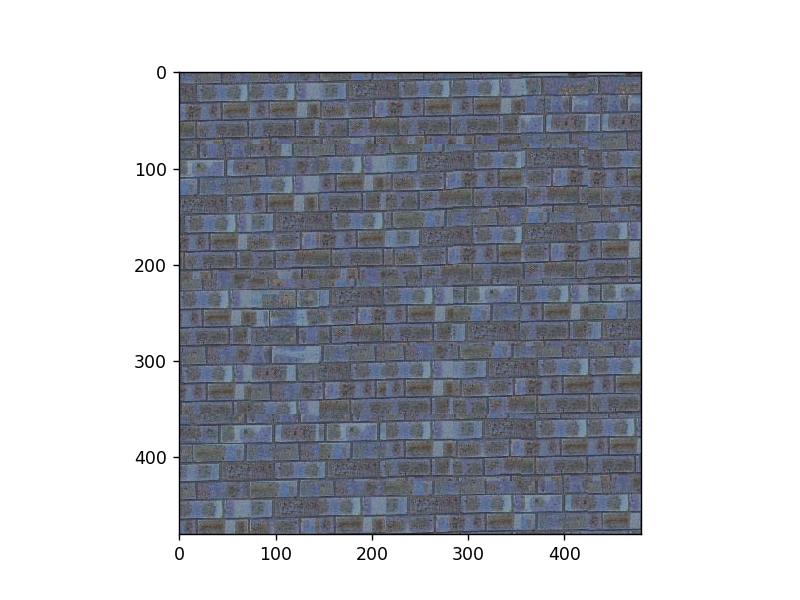

In [351]:
wall_2 = quilt_simple(sample_img, 500, 80, 10, 0.01)
plt.imshow(wall_2[:-20,:-20,:])

11025
0 0
0 50
0 100
0 150
0 200
0 250
0 300
0 350
0 400
0 450
0 500
50 0
50 50
50 100
50 150
50 200
50 250
50 300
50 350
50 400
50 450
50 500
100 0
100 50
100 100
100 150
100 200
100 250
100 300
100 350
100 400
100 450
100 500
150 0
150 50
150 100
150 150
150 200
150 250
150 300
150 350
150 400
150 450
150 500
200 0
200 50
200 100
200 150
200 200
200 250
200 300
200 350
200 400
200 450
200 500
250 0
250 50
250 100
250 150
250 200
250 250
250 300
250 350
250 400
250 450
250 500
300 0
300 50
300 100
300 150
300 200
300 250
300 300
300 350
300 400
300 450
300 500
350 0
350 50
350 100
350 150
350 200
350 250
350 300
350 350
350 400
350 450
350 500
400 0
400 50
400 100
400 150
400 200
400 250
400 300
400 350
400 400
400 450
400 500
450 0
450 50
450 100
450 150
450 200
450 250
450 300
450 350
450 400
450 450
450 500
500 0
500 50
500 100
500 150
500 200
500 250
500 300
500 350
500 400
500 450
500 500


<IPython.core.display.Javascript object>


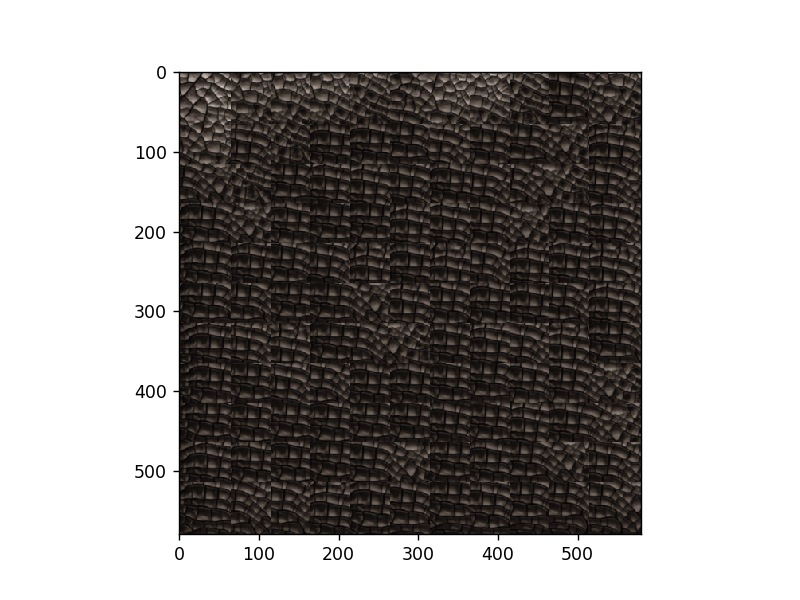

In [356]:
drought_2 = quilt_simple(drought , 600, 80, 30, 0.2) #feel free to change parameters to get best results

<IPython.core.display.Javascript object>


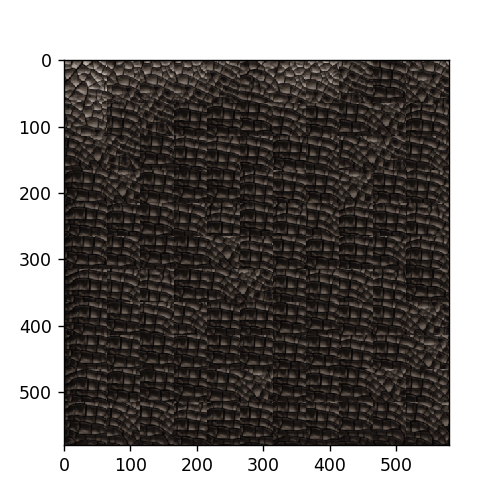

In [373]:
plt.figure(figsize = (4,4))
plt.imshow(drought_2[:-20, :-20, :])

### Part III: Seam Finding (20 pts)


In [11]:
def get_horizontal_mask(cost, overlap):
    template = cost[:, 0 : overlap]
    return cut(template.T).T
    
def get_vertical_mask(cost, overlap):
    template = cost[0 : overlap, :]
    return cut(template)

def ssd_patch(M, T, I):
    ## ssd 
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [12]:
def get_all_patches(sample, patch_size):
    all_patches = {}
    count = -1
    for i in range(sample.shape[0]):
        if sample.shape[0] - i < patch_size:
            break
        for j in range(sample.shape[1]):
            if sample.shape[1] - j < patch_size:
                continue
            count += 1
            all_patches[count] = sample[i : i + patch_size, j : j + patch_size, :]
    return all_patches
            
        
def ssd_cost(M, T, I):
    # return one channel
    useful_I = np.zeros(I.shape)
    useful_I[:,:,0], useful_I[:,:,1], useful_I[:,:,2] = M * I[:,:,0], M * I[:,:,1], M * I[:,:,2]
    return np.sum((T - useful_I) ** 2, -1)

    
def choose_sample_p3(sample, patch_size, M, T, tol, all_patches):
#     cost_image = np.zeros([sample.shape[0] - patch_size, sample.shape[0]- patch_size])
    proportion = 0.1
    cost = {}
    cost_image = {}
    n = len(all_patches)
    index = np.random.choice(n, int(proportion * n))

    for i in index:
        temp_cost = ssd_cost(M, T, all_patches[i])
        cost[i] = np.sum(temp_cost)
        cost_image[i] = temp_cost
    
    min_value = min(cost.values())
    choices = []
    cost_images = []
    for key in cost_image.keys():
        if cost[key] <= min_value * (1 + tol):
            choices.append(all_patches[key])
            cost_images.append(cost_image[key])
    
    index = np.random.choice(len(choices))
    return choices[index], cost_images[index] 

def fill_horizontal(i, j, patch_size, overlap, mask, rgb_output, rgb_sample):
    overlap_rgb = rgb_output[i : i + patch_size, j : j + overlap, :]
    
    for k in range(3):
        overlap_rgb[:,:,k] =  rgb_sample[:,:overlap,k] * mask  + (1 - mask) * overlap_rgb[:,:,k]
        
    
    
def fill_vertical(i, j, patch_size, overlap, mask, rgb_output, rgb_sample):
    overlap_rgb = rgb_output[i : i + overlap, j : j + patch_size, :]
    for k in range(3):
        overlap_rgb[:,:,k] =  rgb_sample[:overlap,:,k] * mask  + (1 - mask) * overlap_rgb[:,:,k]
#     overlap_rgb = (rgb_sample[:overlap, :, :].T * rgb_mask).T + ((1 - rgb_mask) * overlap_rgb.T).T


def fill_leftover_horizontal(i, j, patch_size, overlap, rgb_output, rgb_sample):
    rgb_output[i : i + patch_size, j + overlap : j + patch_size,:] = rgb_sample[:, overlap:,:]
    
def fill_leftover_vertical(i, j, patch_size, overlap, rgb_output, rgb_sample):
    rgb_output[i + overlap : i + patch_size, j : j + patch_size,:] = rgb_sample[overlap:, :,:]

def fill_leftover(i, j, patch_size, overlap, rgb_output,rgb_sample):
    rgb_output[i + overlap : i + patch_size, j + overlap : j + patch_size,:] = rgb_sample[overlap:, overlap:,:]

def put_new_sample(i, j, overlap, patch_size, new_sample, sample):
    if i == 0 and j == 0:
        sample[i : i + patch_size, j : j + patch_size] = new_sample
    elif j == 0 and i != 0:
        sample[i + overlap // 2 : i + patch_size, j : j + patch_size] = new_sample[overlap // 2:, :, :]
    elif j != 0 and i == 0:
        
        sample[i: i + patch_size, j + overlap // 2 : j + patch_size] = new_sample[:, overlap // 2:, :]
    else:
        sample[i + overlap // 2 : i + patch_size, j + overlap // 2 : j + patch_size] = new_sample[overlap // 2:, overlap // 2:, :]
        
        
        
        
        

def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    sample = sample.copy() / 255.0
    patches = get_all_patches(sample, patch_size)
    step = patch_size - overlap
    output = np.zeros([out_size, out_size, 3])
    
    for i in range(0, out_size + 1, step):
        if out_size - i < patch_size:
            break
        for j in range(0, out_size + 1, step):
            print(i, j)
            if out_size - j < patch_size:
                continue
            M = (output[i : i + patch_size, j : j + patch_size, 0] != 0)
#             print(M.shape)
            T = (output[i : i + patch_size, j : j + patch_size, :])
            new_sample, cost = choose_sample_p3(sample, patch_size, M, T, tol, patches)
            
            if i == 0 and j == 0:
                index = np.random.choice(len(patches))
                put_new_sample(i, j, overlap, patch_size, patches[index], output)
                
            elif i == 0 and j != 0:
                mask = get_horizontal_mask(cost, overlap)
                fill_horizontal(i, j, patch_size, overlap, mask, output,new_sample)
                fill_leftover_horizontal(i, j, patch_size, overlap, output, new_sample)
                
            elif i != 0 and j == 0:
                mask = get_vertical_mask(cost, overlap)
                fill_vertical(i, j, patch_size, overlap, mask, output, new_sample)
                fill_leftover_vertical(i, j, patch_size, overlap, output, new_sample)
                
            else:
                mask = get_horizontal_mask(cost, overlap)
                fill_horizontal(i, j, patch_size, overlap, mask, output, new_sample)  
                cost = ssd_cost(M, T, new_sample)
                mask = get_vertical_mask(cost, overlap)
                fill_vertical(i, j, patch_size, overlap, mask, output, new_sample)
                fill_leftover(i, j, patch_size, overlap, output, new_sample)
                
                
    return output

In [ ]:
bricks = quilt_cut(sample_img, 600, 80, 20, 0.005)

<IPython.core.display.Javascript object>


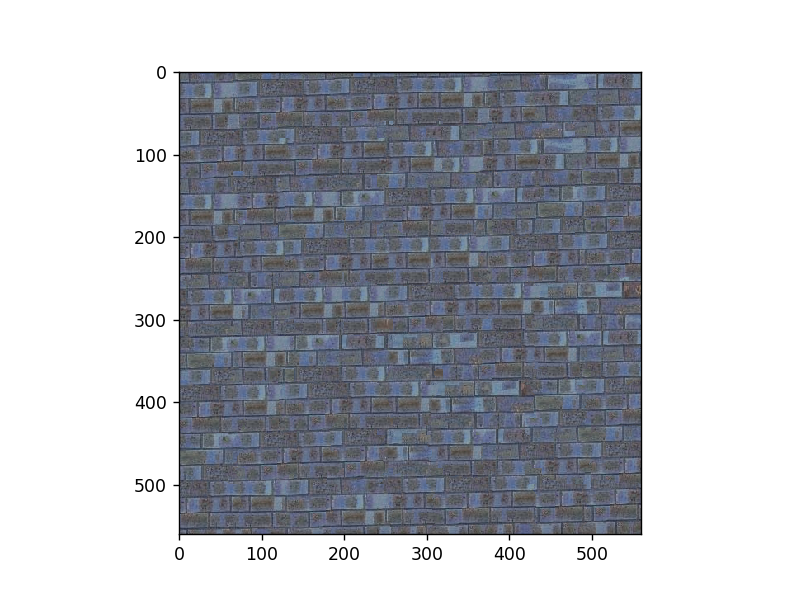

In [488]:
plt.imshow(bricks[:-40,:-40,:])
plt.show()

In [456]:
meat_3 = quilt_cut(meat, 500, 80, 15, 0.01)

0 0
0 65
0 130
0 195
0 260
0 325
0 390
0 455
65 0
65 65
65 130
65 195
65 260
65 325
65 390
65 455
130 0
130 65
130 130
130 195
130 260
130 325
130 390
130 455
195 0
195 65
195 130
195 195
195 260
195 325
195 390
195 455
260 0
260 65
260 130
260 195
260 260
260 325
260 390
260 455
325 0
325 65
325 130
325 195
325 260
325 325
325 390
325 455
390 0
390 65
390 130
390 195
390 260
390 325
390 390
390 455


<IPython.core.display.Javascript object>


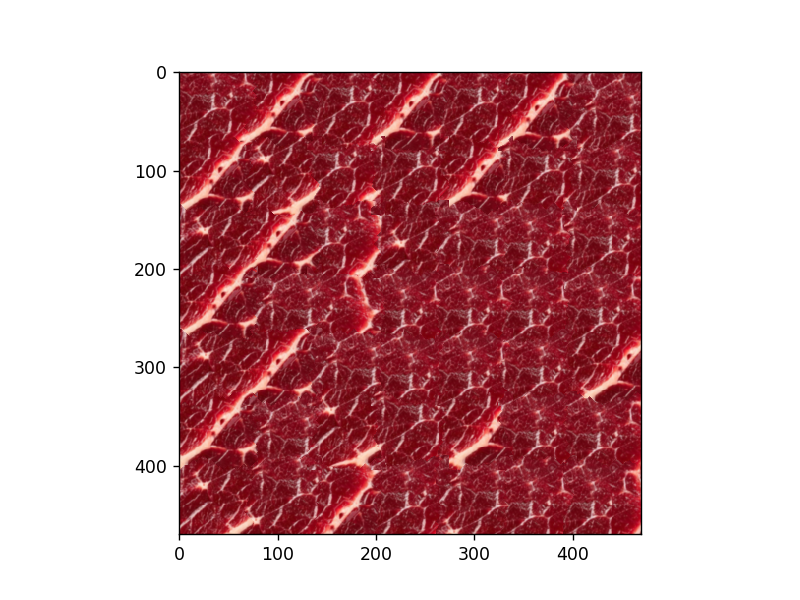

In [457]:
plt.imshow(meat_3[:-30,:-30,:])

<IPython.core.display.Javascript object>


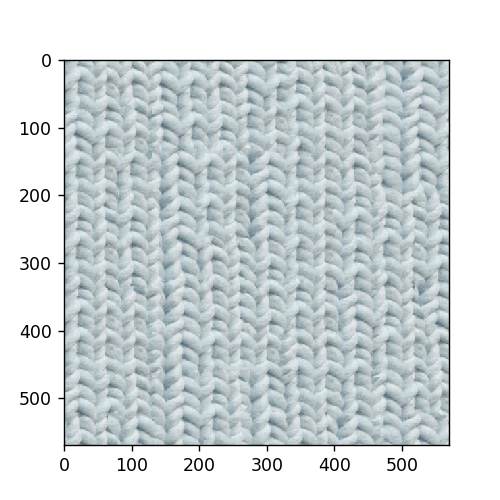

In [463]:
cotton_3 = quilt_cut(cotton, 600, 80,15, 0.05)
plt.figure(figsize=(4,4))
plt.imshow(cotton_3[:-30, :-30, :])
plt.show()

<IPython.core.display.Javascript object>


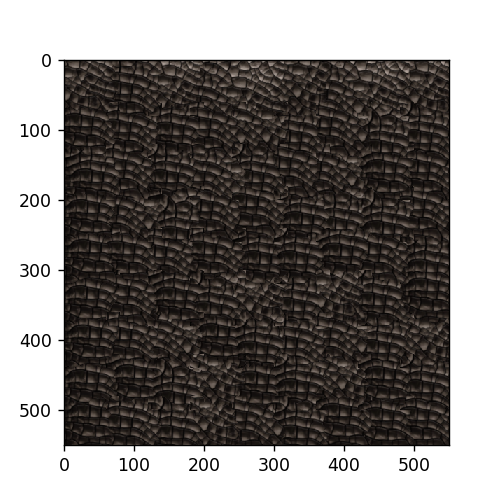

In [489]:
drought_3 = quilt_cut(drought, 600, 80, 20, 0.3)
plt.figure(figsize=(4,4))
plt.imshow(drought_3[:-50, :-50, :])

0 0
0 35
0 70
0 105
0 140
0 175
0 210
0 245
0 280
35 0
35 35
35 70
35 105
35 140
35 175
35 210
35 245
35 280
70 0
70 35
70 70
70 105
70 140
70 175
70 210
70 245
70 280
105 0
105 35
105 70
105 105
105 140
105 175
105 210
105 245
105 280
140 0
140 35
140 70
140 105
140 140
140 175
140 210
140 245
140 280
175 0
175 35
175 70
175 105
175 140
175 175
175 210
175 245
175 280
210 0
210 35
210 70
210 105
210 140
210 175
210 210
210 245
210 280
245 0
245 35
245 70
245 105
245 140
245 175
245 210
245 245
245 280


<IPython.core.display.Javascript object>


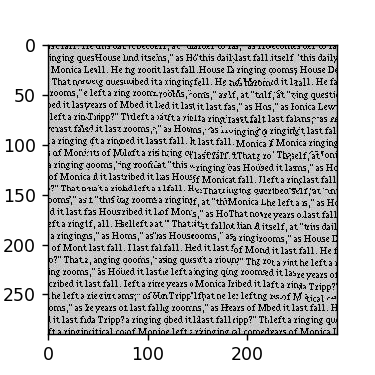

In [487]:
text_3 = quilt_cut(text, 300, 50, 15, 0.1)
plt.figure(figsize = (3,3))
plt.imshow(text_3[:-10,:-10,:])

### part IV: Texture Transfer (30 pts)

(178, 136, 3)


<IPython.core.display.Javascript object>


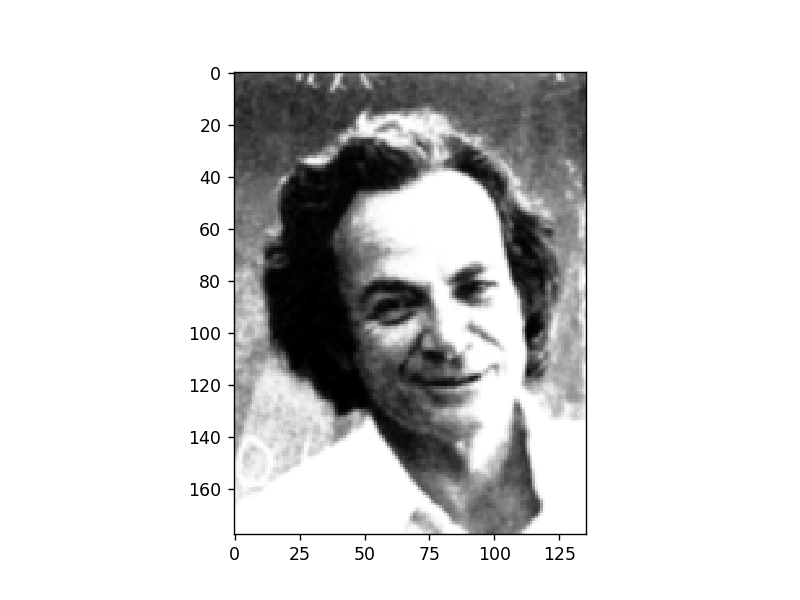

In [485]:
target = cv2.imread("samples/feynman.tiff")
target = cv2.pyrDown(target)
print(target.shape)
plt.imshow(target)
plt.show()

(202, 202, 3)


<IPython.core.display.Javascript object>


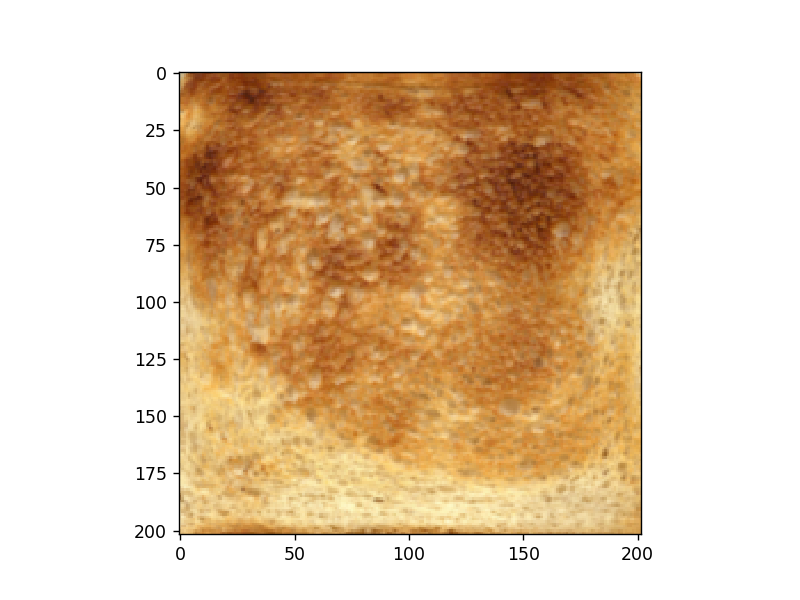

In [486]:
texture = cv2.imread("samples/toast.jpg")
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
texture = cv2.pyrDown(texture)[20:-20, 20:-28, :]
print(texture.shape)
plt.imshow(texture)
plt.show()

In [612]:
def get_all_patches(sample, patch_size):
    all_patches = {}
    count = -1
    for i in range(sample.shape[0]):
        if sample.shape[0] - i < patch_size:
            break
        for j in range(sample.shape[1]):
            if sample.shape[1] - j < patch_size:
                continue
            count += 1
            all_patches[count] = sample[i : i + patch_size, j : j + patch_size, :]
    return all_patches
            
        
def ssd_cost(M, T, I):
    # return one channel
    useful_I = np.zeros(I.shape)
    useful_I[:,:,0], useful_I[:,:,1], useful_I[:,:,2] = M * I[:,:,0], M * I[:,:,1], M * I[:,:,2]
    return np.sum((T - useful_I) ** 2, -1)

    
def choose_sample_p4(patch_size, M, T, tol, target, all_patches):
#     cost_image = np.zeros([sample.shape[0] - patch_size, sample.shape[0]- patch_size])
    proportion = 0.05
    cost = {}
    cost_image = {}
    n = len(all_patches)
    index = np.random.choice(n, int(proportion * n))

    for i in index:
        alpha = np.sum(M) / (M.shape[0] * M.shape[1])
        temp_cost = ssd_cost(M, T, all_patches[i])
        cost2 = ssd_cost(np.ones([patch_size, patch_size]), target, all_patches[i])
        cost[i] = alpha * np.sum(temp_cost) + (1 - alpha) * np.sum(cost2)
        cost_image[i] = temp_cost
    
    min_value = min(cost.values())
    choices = []
    cost_images = []
    for key in cost_image.keys():
        if cost[key] <= min_value * (1 + tol):
            choices.append(all_patches[key])
            cost_images.append(cost_image[key])
    
    index = np.random.choice(len(choices))
    return choices[index], cost_images[index] 



def fill_horizontal(i, j, patch_size, overlap, mask, rgb_output, rgb_sample):
    overlap_rgb = rgb_output[i : i + patch_size, j : j + overlap, :]
    
    for k in range(3):
        overlap_rgb[:,:,k] =  rgb_sample[:,:overlap,k] * mask  + (1 - mask) * overlap_rgb[:,:,k]
        
    
    
def fill_vertical(i, j, patch_size, overlap, mask, rgb_output, rgb_sample):
    overlap_rgb = rgb_output[i : i + overlap, j : j + patch_size, :]
    for k in range(3):
        overlap_rgb[:,:,k] =  rgb_sample[:overlap,:,k] * mask  + (1 - mask) * overlap_rgb[:,:,k]


def fill_leftover_horizontal(i, j, patch_size, overlap, rgb_output, rgb_sample):
    rgb_output[i : i + patch_size, j + overlap : j + patch_size,:] = rgb_sample[:, overlap:,:]
    
def fill_leftover_vertical(i, j, patch_size, overlap, rgb_output, rgb_sample):
    rgb_output[i + overlap : i + patch_size, j : j + patch_size,:] = rgb_sample[overlap:, :,:]

def fill_leftover(i, j, patch_size, overlap, rgb_output,rgb_sample):
    rgb_output[i + overlap : i + patch_size, j + overlap : j + patch_size,:] = rgb_sample[overlap:, overlap:,:]

def put_new_sample(i, j, overlap, patch_size, new_sample, sample):
    if i == 0 and j == 0:
        sample[i : i + patch_size, j : j + patch_size] = new_sample
    elif j == 0 and i != 0:
        sample[i + overlap // 2 : i + patch_size, j : j + patch_size] = new_sample[overlap // 2:, :, :]
    elif j != 0 and i == 0:
        
        sample[i: i + patch_size, j + overlap // 2 : j + patch_size] = new_sample[:, overlap // 2:, :]
    else:
        sample[i + overlap // 2 : i + patch_size, j + overlap // 2 : j + patch_size] = new_sample[overlap // 2:, overlap // 2:, :]
        
      
    
    
def texture_transfer(texture, target, patch_size, overlap, tol):
    """
    Feel free to add function parameters
    """
    texture = texture.copy() / 255.0
    step = patch_size - overlap
    output = target.copy() / 255.0
    patches = get_all_patches(texture, patch_size)
    
    
    for i in range(0, target.shape[0] + 1, step):
        if target.shape[0] - i < patch_size:
            break
        for j in range(0, target.shape[1] + 1, step):
            print(i, j)
            if target.shape[1] - j < patch_size:
                continue
            M = (output[i : i + patch_size, j : j + patch_size, 0] != 0).astype(int)
            T = (output[i : i + patch_size, j : j + patch_size, :])
            rgb_texture_sample, cost = choose_sample_p4(patch_size, M, T,\
                                                                     tol, output[i:i + patch_size, j : j + patch_size], patches)
            if i == 0 and j == 0:
                put_new_sample(i, j, overlap, patch_size, rgb_texture_sample, output)
                
            elif i == 0 and j != 0:
                mask = get_horizontal_mask(cost, overlap)
                fill_horizontal(i, j, patch_size, overlap, mask, output,rgb_texture_sample)
                fill_leftover_horizontal(i, j, patch_size, overlap, output, rgb_texture_sample)
                
            elif i != 0 and j == 0:
                mask = get_vertical_mask(cost, overlap)
                fill_vertical(i, j, patch_size, overlap, mask, output, rgb_texture_sample)
                fill_leftover_vertical(i, j, patch_size, overlap, output, rgb_texture_sample)
                
            else:
                mask = get_horizontal_mask(cost, overlap)
                fill_horizontal(i, j, patch_size, overlap, mask, output, rgb_texture_sample)  
                cost = ssd_cost(M, T, rgb_texture_sample)
                mask = get_vertical_mask(cost, overlap)
                fill_vertical(i, j, patch_size, overlap, mask, output, rgb_texture_sample)
                fill_leftover(i, j, patch_size, overlap, output, rgb_texture_sample)
                

    return output

In [541]:
toast_man = texture_transfer(texture, target, 11, 3, 0.1)

0 0
0 8
0 16
0 24
0 32
0 40
0 48
0 56
0 64
0 72
0 80
0 88
0 96
0 104
0 112
0 120
0 128
0 136
8 0
8 8
8 16
8 24
8 32
8 40
8 48
8 56
8 64
8 72
8 80
8 88
8 96
8 104
8 112
8 120
8 128
8 136
16 0
16 8
16 16
16 24
16 32
16 40
16 48
16 56
16 64
16 72
16 80
16 88
16 96
16 104
16 112
16 120
16 128
16 136
24 0
24 8
24 16
24 24
24 32
24 40
24 48
24 56
24 64
24 72
24 80
24 88
24 96
24 104
24 112
24 120
24 128
24 136
32 0
32 8
32 16
32 24
32 32
32 40
32 48
32 56
32 64
32 72
32 80
32 88
32 96
32 104
32 112
32 120
32 128
32 136
40 0
40 8
40 16
40 24
40 32
40 40
40 48
40 56
40 64
40 72
40 80
40 88
40 96
40 104
40 112
40 120
40 128
40 136
48 0
48 8
48 16
48 24
48 32
48 40
48 48
48 56
48 64
48 72
48 80
48 88
48 96
48 104
48 112
48 120
48 128
48 136
56 0
56 8
56 16
56 24
56 32
56 40
56 48
56 56
56 64
56 72
56 80
56 88
56 96
56 104
56 112
56 120
56 128
56 136
64 0
64 8
64 16
64 24
64 32
64 40
64 48
64 56
64 64
64 72
64 80
64 88
64 96
64 104
64 112
64 120
64 128
64 136
72 0
72 8
72 16
72 24
72 32
72 40
72 

<IPython.core.display.Javascript object>


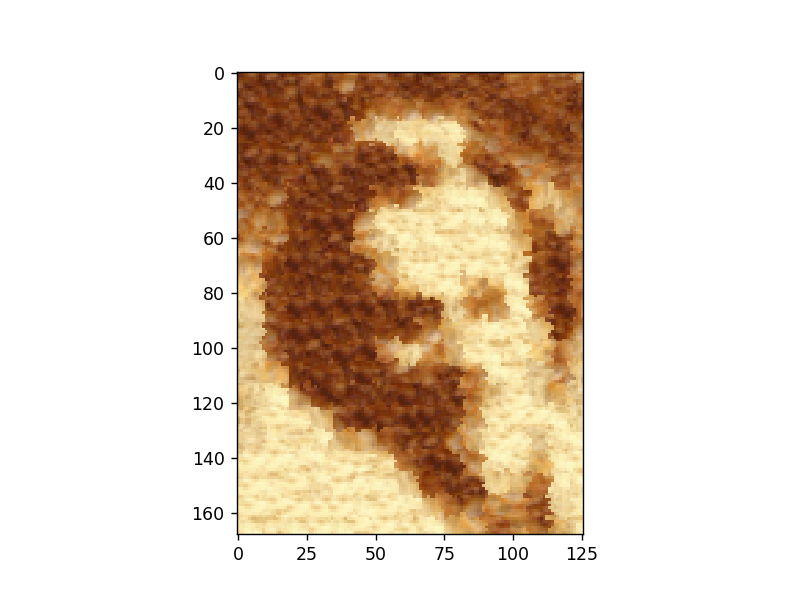

In [542]:
plt.imshow(toast_man[:-10, :-10, :])

<IPython.core.display.Javascript object>


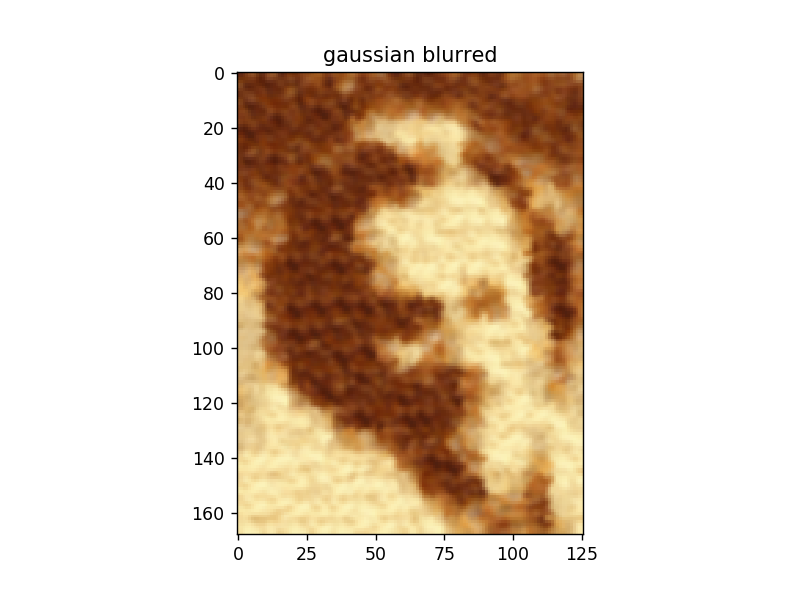

Text(0.5, 1.0, 'gaussian blurred')

In [552]:
plt.imshow((cv2.GaussianBlur(toast_man[:-10,:-10,:], (3, 3), 0.5)) ** 1.05)
plt.title("gaussian blurred")

(144, 108, 3)
(124, 270, 3)
(193, 256, 3)


<IPython.core.display.Javascript object>


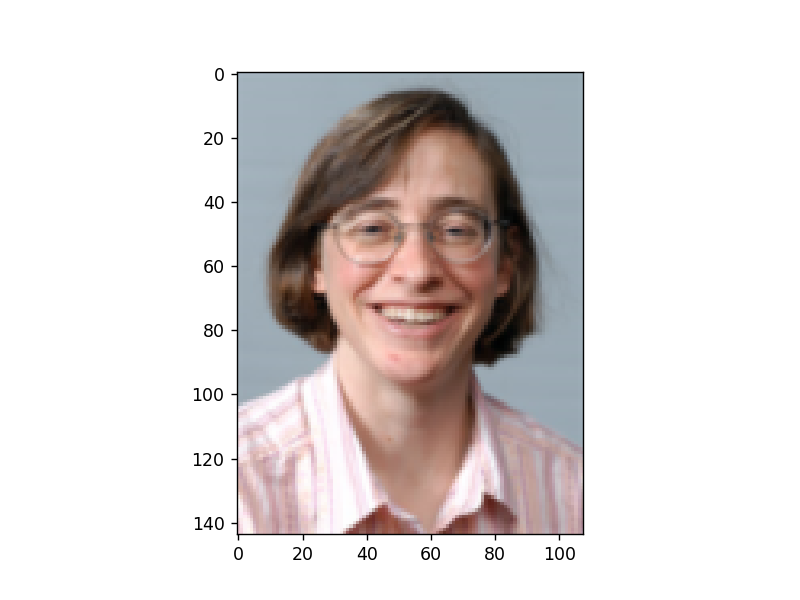

In [609]:
fleck = cv2.imread("samples/fleck.png")
fleck = cv2.cvtColor(fleck, cv2.COLOR_BGR2RGB)
fleck = cv2.pyrDown(fleck)
print(fleck.shape)
noodles = cv2.imread("samples/noodles.jpg")
noodles = cv2.cvtColor(noodles, cv2.COLOR_BGR2RGB)[100:-80, 50:-50, :]
noodels = cv2.pyrDown(noodles)
print(noodels.shape)
print(sky.shape)
plt.imshow(fleck)
plt.show()

<IPython.core.display.Javascript object>


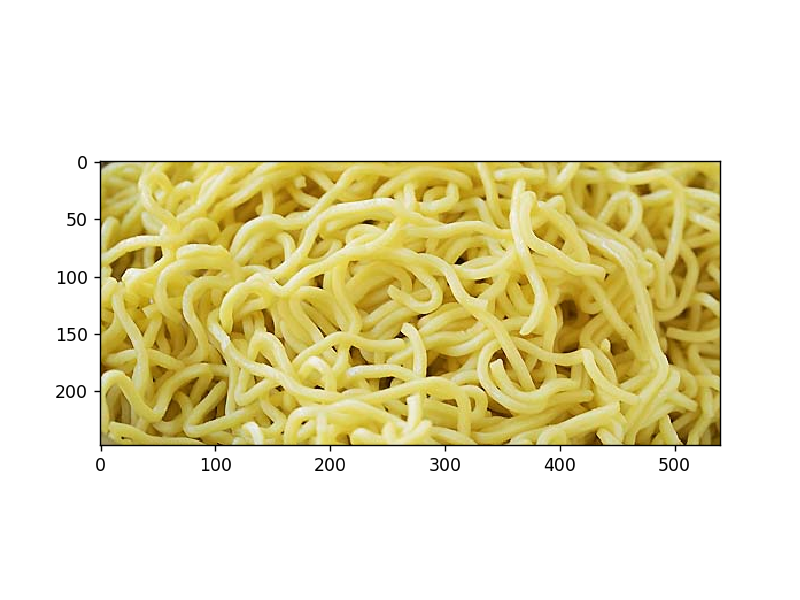

In [610]:
plt.imshow(noodles)

In [613]:
noodle_fleck = texture_transfer(noodles, fleck, 10, 3, 0.05)

0 0
0 7
0 14
0 21
0 28
0 35
0 42
0 49
0 56
0 63
0 70
0 77
0 84
0 91
0 98
0 105
7 0
7 7
7 14
7 21
7 28
7 35
7 42
7 49
7 56
7 63
7 70
7 77
7 84
7 91
7 98
7 105
14 0
14 7
14 14
14 21
14 28
14 35
14 42
14 49
14 56
14 63
14 70
14 77
14 84
14 91
14 98
14 105
21 0
21 7
21 14
21 21
21 28
21 35
21 42
21 49
21 56
21 63
21 70
21 77
21 84
21 91
21 98
21 105
28 0
28 7
28 14
28 21
28 28
28 35
28 42
28 49
28 56
28 63
28 70
28 77
28 84
28 91
28 98
28 105
35 0
35 7
35 14
35 21
35 28
35 35
35 42
35 49
35 56
35 63
35 70
35 77
35 84
35 91
35 98
35 105
42 0
42 7
42 14
42 21
42 28
42 35
42 42
42 49
42 56
42 63
42 70
42 77
42 84
42 91
42 98
42 105
49 0
49 7
49 14
49 21
49 28
49 35
49 42
49 49
49 56
49 63
49 70
49 77
49 84
49 91
49 98
49 105
56 0
56 7
56 14
56 21
56 28
56 35
56 42
56 49
56 56
56 63
56 70
56 77
56 84
56 91
56 98
56 105
63 0
63 7
63 14
63 21
63 28
63 35
63 42
63 49
63 56
63 63
63 70
63 77
63 84
63 91
63 98
63 105
70 0
70 7
70 14
70 21
70 28
70 35
70 42
70 49
70 56
70 63
70 70
70 77
70 84
70 91


<IPython.core.display.Javascript object>


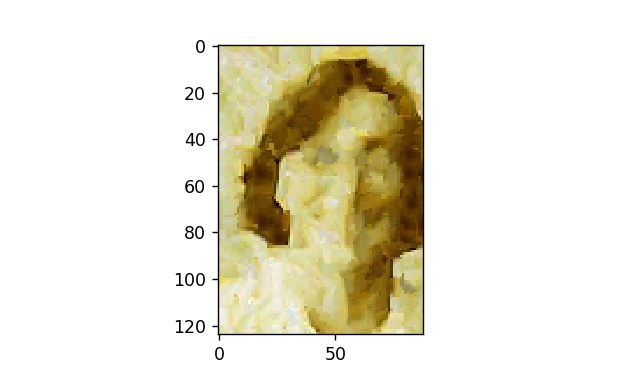

In [615]:
plt.figure(figsize=(5,3))
plt.imshow(noodle_fleck[:-20,:-20,:])

<IPython.core.display.Javascript object>


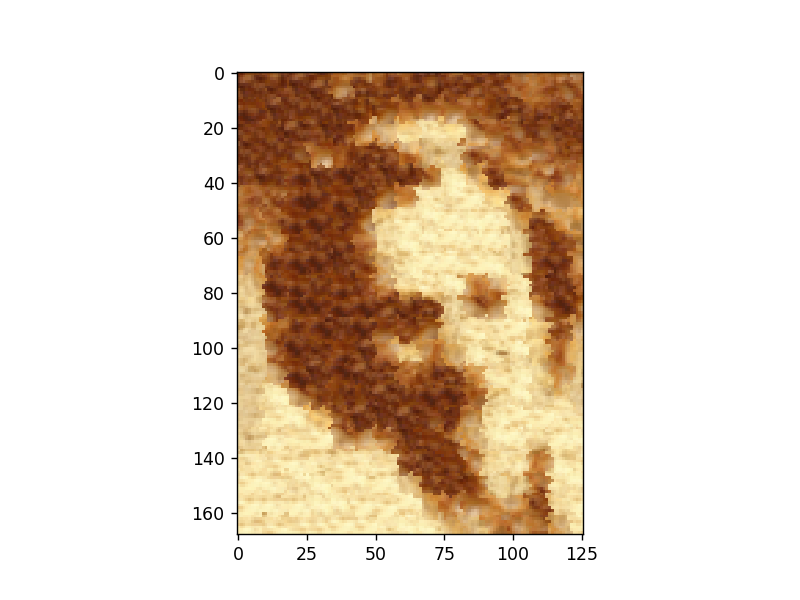

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).

In [193]:
a = {"a" : 1, "b" : 2, "c" : 5, "d":3}
max(a.keys(), key = lambda x : a[x])
sorted(a.keys(), key = lambda x : a[x])

['a', 'b', 'd', 'c']